# Feature Engineering

## 1: Locate and Collect All Eye-Tracking Files

In [120]:
import glob
import os
import random

# Path to the folder containing all eye-tracking text files
# Each .txt file corresponds to one recording session
DATA_DIR = "C:\\Users\\admin\\Desktop\\HPC_ML Course\\RAN"

# Find all .txt files inside the directory
# glob returns a list of full file paths
all_files = glob.glob(os.path.join(DATA_DIR, "*.txt"))

# Print how many recordings we found
print("Total files found:", len(all_files))

Total files found: 306


## 2: Group Files by User ID

In [121]:
# Dictionary to group files by user
# Key   → user ID (e.g., 1, 2, 3)
# Value → list of files belonging to that user
user_files = {}

for f in all_files:
    # File format example: ID_001_1.txt
    # Split filename and extract the user ID (001 → 1)
    uid = int(os.path.basename(f).split("_")[1])

    # Add file to that user's list
    # If the key does not exist, create an empty list first
    user_files.setdefault(uid, []).append(f)

# Print number of unique users found
print("Total users found:", len(user_files))

Total users found: 153


## 3: Select a Subset of Users

In [122]:
# Number of users we want for demonstration
NUM_USERS = 10

# Count how many users are available
num_available_users = len(user_files)

if num_available_users == 0:
    # No data found → stop early
    print("Warning: No user files found. Check the folder path.")
    SELECTED_USERS = []

elif num_available_users < NUM_USERS:
    # If fewer than 10 users exist, use all of them
    print(f"Warning: Only {num_available_users} users found. Using all.")
    SELECTED_USERS = sorted(list(user_files.keys()))

else:
    # Randomly select 10 users
    SELECTED_USERS = sorted(random.sample(list(user_files.keys()), NUM_USERS))

print("Selected users:", SELECTED_USERS)

Selected users: [45, 78, 111, 121, 178, 180, 244, 265, 299, 309]


## 4: Collect Files for Selected Users

In [123]:
# List that will store only the files we want to analyze
selected_files = []

for u in SELECTED_USERS:
    # Add all files belonging to this user
    selected_files.extend(user_files[u])

print("Total selected files:", len(selected_files))

Total selected files: 20


At each time step $t_i$, the eye tracker records a gaze position:

$$
(x_i, y_i), \quad i = 1,2,\dots,N
$$


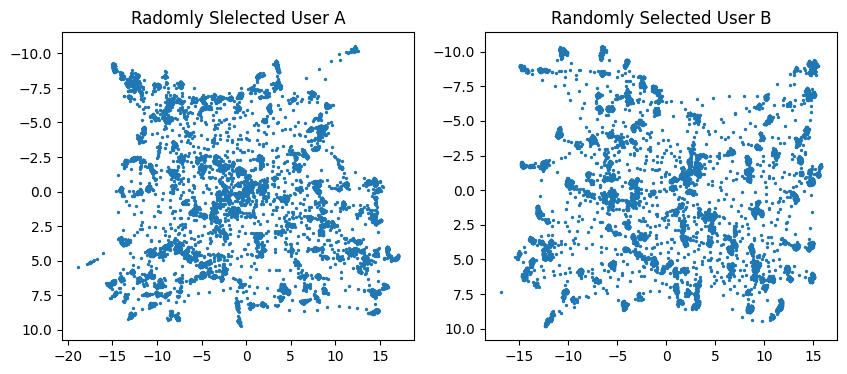

In [124]:
def plot_two_users(file1, file2):
    df1 = load_file(file1)
    df2 = load_file(file2)

    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.scatter(df1["X_DEGREE"], df1["Y_DEGREE"], s=2)
    plt.gca().invert_yaxis()
    plt.title("Radomly Slelected User A")

    plt.subplot(1, 2, 2)
    plt.scatter(df2["X_DEGREE"], df2["Y_DEGREE"], s=2)
    plt.gca().invert_yaxis()
    plt.title("Randomly Selected User B")

    plt.show()

plot_two_users(selected_files[0], selected_files[-1])


## 5: Load and Clean Eye-Tracking Files

In [125]:
import pandas as pd
import numpy as np

def load_file(path):
    """
    Load a BioEye eye-tracking file and remove invalid samples.
    """

    # Read the file using whitespace as separator
    # Skip the first row (header text)
    df = pd.read_csv(
        path,
        sep=r"\s+",
        skiprows=1,
        header=None,
        names=[
        "SAMPLE",
        "X_DEGREE",
        "Y_DEGREE",
        "VALIDITY",
        "X_STIMULUS",
        "Y_STIMULUS"
    ]
    )

    # Keep only rows where gaze data is valid
    # VALID == 1 means the eye tracker successfully detected gaze
    df = df[df["VALIDITY"] == 1]

    # Reset row indices after filtering
    df = df.reset_index(drop=True)

    return df

## 6: Windowing (Temporal Segmentation)

### Split Long Signals into Time Windows

In [126]:
def window_by_index(df, win=6000, step=3000):
    """
    Break a long eye-tracking signal into overlapping time windows.

    win  = number of samples per window
    step = how far we move forward for the next window
    """

    windows = []

    # Slide a window over the data
    for i in range(0, len(df) - win + 1, step):
        # Extract a chunk of consecutive samples
        w = df.iloc[i:i + win]
        windows.append(w)

    return windows


## 6: Feature Engineering (Turning Motion into Numbers)

Mean velocity:

$$
\mu_v = \frac{1}{N} \sum_{i=1}^{N} v_i
$$

Standard deviation:

$$
\sigma_v = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (v_i - \mu_v)^2}
$$

Percentile
$$
P_{75}, \; P_{90}
$$


In [127]:
def extract_features(w):
    """
    Extract numerical features from one gaze window.
    """

    # Difference between consecutive gaze points (horizontal)
    dx = np.diff(w["X_DEGREE"])

    # Difference between consecutive gaze points (vertical)
    dy = np.diff(w["Y_DEGREE"])

    # Velocity magnitude (how fast the eye moves)
    vel = np.sqrt(dx**2 + dy**2)

    # Return a list of statistical features
    return [
        w["X_DEGREE"].mean(),            # Average horizontal gaze position
        w["X_DEGREE"].std(),             # Variability in horizontal gaze
        w["Y_DEGREE"].mean(),            # Average vertical gaze position
        w["Y_DEGREE"].std(),             # Variability in vertical gaze
        vel.mean(),               # Average eye movement speed
        vel.std(),                # Speed variability
        np.percentile(vel, 75),   # Fast movements (upper quartile)
        np.percentile(vel, 90)    # Very fast movements (saccades)
    ]

Eye movement velocity is computed as:

$$
v_i = \sqrt{(x_{i+1} - x_i)^2 + (y_{i+1} - y_i)^2}
$$


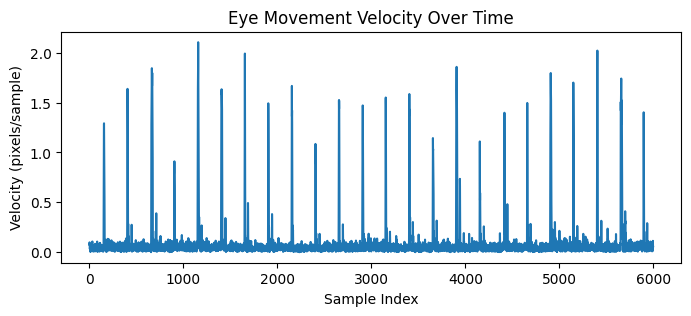

In [137]:
def plot_velocity(w):
    dx = np.diff(w["X_DEGREE"])
    dy = np.diff(w["Y_DEGREE"])
    vel = np.sqrt(dx**2 + dy**2)

    plt.figure(figsize=(8, 3))
    plt.plot(vel)
    plt.xlabel("Sample Index")
    plt.ylabel("Velocity (pixels/sample)")
    plt.title("Eye Movement Velocity Over Time")
    plt.show()

plot_velocity(windows[4])


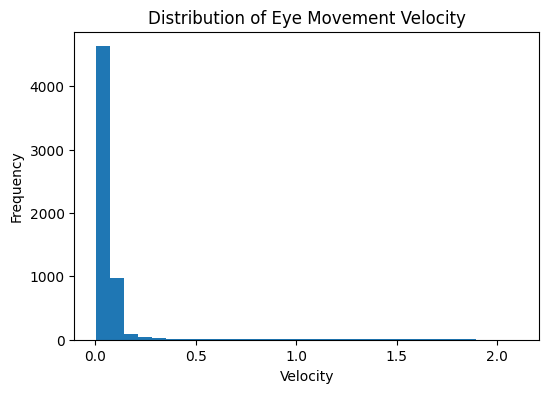

In [138]:
def plot_velocity_histogram(w):
    dx = np.diff(w["X_DEGREE"])
    dy = np.diff(w["Y_DEGREE"])
    vel = np.sqrt(dx**2 + dy**2)

    plt.figure(figsize=(6, 4))
    plt.hist(vel, bins=30)
    plt.xlabel("Velocity")
    plt.ylabel("Frequency")
    plt.title("Distribution of Eye Movement Velocity")
    plt.show()

plot_velocity_histogram(windows[4])

## 7: Build the Feature Matrix (X) and Labels (y)

Each time window is represented as a feature vector:

$$
\mathbf{x} =
[\mu_x,\; \sigma_x,\; \mu_y,\; \sigma_y,\;
\mu_v,\; \sigma_v,\; P_{75},\; P_{90}]
$$


In [139]:
import pandas as pd

feature_names = [
    "X_mean", "X_std", "Y_mean", "Y_std",
    "Vel_mean", "Vel_std", "Vel_75th", "Vel_90th"
]

features = extract_features(windows[4])

df_features = pd.DataFrame([features], columns=feature_names)
df_features


,X_mean,X_std,Y_mean,Y_std,Vel_mean,Vel_std,Vel_75th,Vel_90th
0,-0.143826,8.598228,-1.33308,5.198193,0.094239,0.232485,0.067415,0.103177


Each feature vector is labeled with its user identity:

$$
\mathbf{x}_i \rightarrow y_i
$$


In [128]:
# X → feature matrix (input to machine learning model)
# y → labels (user IDs)
X = []
y = []

for f in selected_files:
    # Extract user ID from filename
    uid = int(os.path.basename(f).split("_")[1])

    # Load and clean gaze data
    df = load_file(f)

    # Split recording into time windows
    windows = window_by_index(df)

    for w in windows:
        # Extract numerical features from window
        features = extract_features(w)

        # Store features and corresponding user ID
        X.append(features)
        y.append(uid)

## 8: Convert to NumPy Arrays

In [132]:
# Convert lists to NumPy arrays
X = np.array(X)
y = np.array(y)

print("Total samples:", X.shape[0])
print("Features per sample:", X.shape[1])
print("Number of unique users:", len(np.unique(y)))

Total samples: 130
Features per sample: 8
Number of unique users: 10
